In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load
from anfis import predict 
import pyswarms as ps 

# ==============================================================================
# 1. Carga de Modelos y Datos
# ==============================================================================

try:
    anfis_model = load("models/anfis_model.pkl")
    scaler_X = load("models/scaler_X.pkl")
    scaler_y = load("models/scaler_y.pkl")
except FileNotFoundError:
    print("Error: 'anfis_model.pkl', 'scaler_X.pkl' y 'scaler_y.pkl'")
    exit()

# Límites físicos del espacio de búsqueda (Tiempo, Voltaje, Catalizador)
BOUNDS = np.array([
    [10.0, 30.0],   # tiempo (min)
    [ 2.4,  3.0],   # voltaje (V)
    [ 5.0, 15.0],   # catalizador (µg)
])

min_bound = BOUNDS[:,0]
max_bound = BOUNDS[:,1]
bounds = (min_bound, max_bound)



In [2]:
# ==============================================================================
# 2. Definición de la Función Objetivo (ANFIS como Surrogate Model)
# ==============================================================================

def predict_h2(X_raw):
    """Predice H2 (mL) dado X_raw en espacio físico (no normalizado)."""
    X_scaled = scaler_X.transform(X_raw)
    y_scaled = predict(anfis_model, X_scaled)
    # Desnormalizar y aplanar
    return scaler_y.inverse_transform(y_scaled.reshape(-1,1)).ravel()

def objective(X):
    """Función objetivo: Devuelve -H2 (costo) para la minimización de PSO."""
    h2_vals = predict_h2(X)
    return -h2_vals 


In [3]:
# ==============================================================================
# 3. Configuración y Ejecución de PSO
# ==============================================================================

# Coeficientes: Utilizamos los valores que dieron la convergencia visual más gradual
options = {'c1': 1.7, 'c2': 1.0, 'w': 0.7} 
N_PARTICLES = 500 
DIMENSIONS = 3
ITERS = 1000

# Inicializar optimizador
optimizer = ps.single.GlobalBestPSO(
    n_particles=N_PARTICLES,   # número de partículas
    dimensions=DIMENSIONS,     # tiempo, voltaje, catalizador
    options=options,
    bounds=bounds,
    ftol=1e-3,      # tolerancia mínima de mejora en el coste
    ftol_iter=30 
)

print("\n=======================================================")
print("=== Iniciando Optimización PSO con PYSwarmS (Standard) ===")
print("=======================================================")

# Ejecutar optimización 
cost, pos = optimizer.optimize(objective, iters=ITERS, verbose=True)

# Extraer resultados finales
best_h2 = -cost

# Extraer historiales de la librería
cost_history = np.array(optimizer.cost_history)


2025-11-14 03:57:43,155 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 1.7, 'c2': 1.0, 'w': 0.7}



=== Iniciando Optimización PSO con PYSwarmS (Standard) ===


pyswarms.single.global_best:   6%|▌         |59/1000, best_cost=-101
2025-11-14 03:57:50,349 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -100.81608450660578, best pos: [29.93290744  2.99612921 10.90221922]



=== Resultados Óptimos de la Optimización ANFIS-PSO ===
Mejor Costo Encontrado (Minimizado): -100.816
Producción Máxima de H₂ Estimada: 100.816 mL
Tiempo Óptimo (min): 29.933
Voltaje Óptimo (V): 2.996
Catalizador Óptimo (µg): 10.902


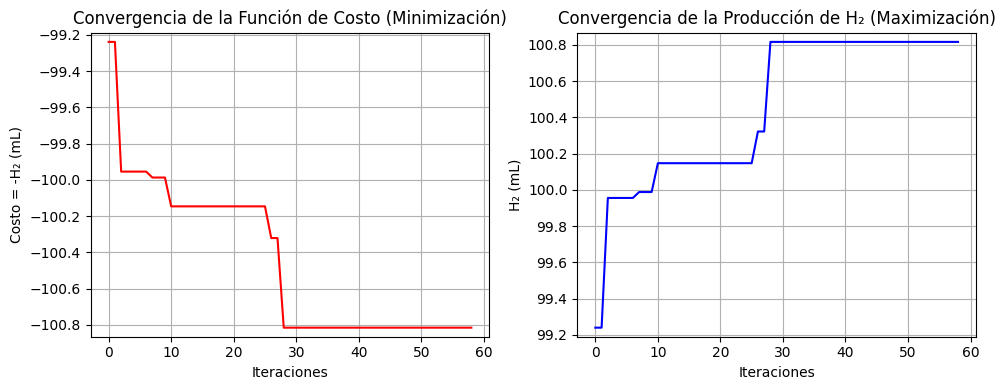

In [4]:
# ==============================================================================
# 4. Interpretación de Resultados y Visualización
# ==============================================================================

print("\n=======================================================")
print("=== Resultados Óptimos de la Optimización ANFIS-PSO ===")
print("=======================================================")
print(f"Mejor Costo Encontrado (Minimizado): {cost:.3f}") 
print(f"Producción Máxima de H₂ Estimada: {best_h2:.3f} mL")
print(f"Tiempo Óptimo (min): {pos[0]:.3f}")
print(f"Voltaje Óptimo (V): {pos[1]:.3f}")
print(f"Catalizador Óptimo (µg): {pos[2]:.3f}")

plt.figure(figsize=(10, 4))

# Gráfico 1: Convergencia en Costo
plt.subplot(1, 2, 1)
plt.plot(cost_history[1:], color='red', label='Costo (-H₂)') 
plt.title("Convergencia de la Función de Costo (Minimización)")
plt.xlabel("Iteraciones")
plt.ylabel("Costo = -H₂ (mL)")
plt.grid(True)
plt.ylim(cost_history.min() - 0.05, cost_history[1:].max() + 0.05)


# Gráfico 2: Convergencia en Producción de H₂ (Valor Positivo)
plt.subplot(1, 2, 2)
plt.plot(-cost_history[1:], color='blue', label='H₂')
plt.title("Convergencia de la Producción de H₂ (Maximización)")
plt.xlabel("Iteraciones")
plt.ylabel("H₂ (mL)")
plt.grid(True)
plt.ylim((-cost_history[1:].max()) - 0.05, (-cost_history.min()) + 0.05)

plt.tight_layout()
plt.show()